In [1]:
import os
import importlib

import numpy as np
import pandas as pd
import pywt
from matplotlib import pyplot as plt
import plotly.express as px
from scipy.signal import savgol_filter

from DMSP import funcs
from DMSP.funcs import mu0,mo,mh,mhe
importlib.reload(funcs)

<module 'funcs' from 'G:\\master\\pyWave\\funcs.py'>

In [2]:
# ssies3
dir = r"data\2014\f16\ssm"
fn = "dmsp-f16_ssm_magnetometer_20140101_v1.0.4.cdf"
fp = os.path.join(dir,fn)
ssm_data = funcs.process_ssm_data(fp)

# ssm
dir = r"data\2014\f16\ssies3"
fn = "dmsp-f16_ssies-3_thermal-plasma_201401011654_v01.cdf"
fp = os.path.join(dir,fn)
ssies3_data = funcs.process_ssies3_data(fp)
# ssm_clip
ssm_data_clip = funcs.clip_ssm_by_ssies3(ssies3_data, ssm_data)

In [3]:
b = funcs.ssm_sc_to_ssies_sc(ssm_data_clip['DELTA_B_SC_x'], ssm_data_clip['DELTA_B_SC_y'], ssm_data_clip['DELTA_B_SC_z'])
B = funcs.ssm_sc_to_ssies_sc(ssm_data_clip['B_SC_OBS_ORIG_x'], ssm_data_clip['B_SC_OBS_ORIG_y'], ssm_data_clip['B_SC_OBS_ORIG_z'])

B01 = (ssm_data_clip['B_SC_OBS_ORIG_x'] - ssm_data_clip['DELTA_B_SC_x'])
B02 = (ssm_data_clip['B_SC_OBS_ORIG_y'] - ssm_data_clip['DELTA_B_SC_y'])
B03 = (ssm_data_clip['B_SC_OBS_ORIG_z'] - ssm_data_clip['DELTA_B_SC_z'])

(<Axes: xlabel='Epoch'>, <Axes: xlabel='Epoch'>)

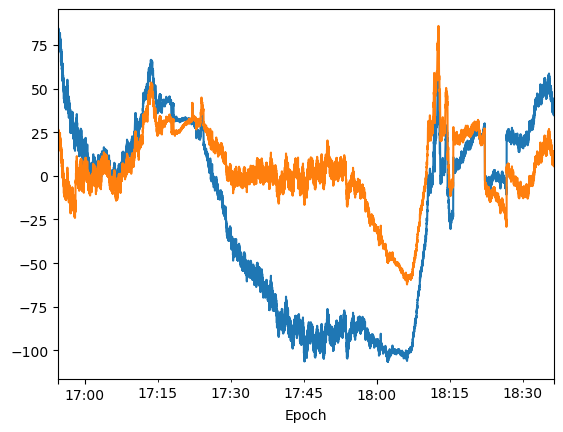

In [4]:
ssm_data_clip['DELTA_B_SC_ORIG_x'].plot(),ssm_data_clip['DELTA_B_SC_x'].plot()

In [5]:
v = ssies3_data[['vx','vy','vz']]

In [6]:
E = pd.DataFrame(np.cross(v.values, B.values) * 1e-6 * -1, columns=['1', '2', '3'], index=b.index)

<Axes: xlabel='Epoch'>

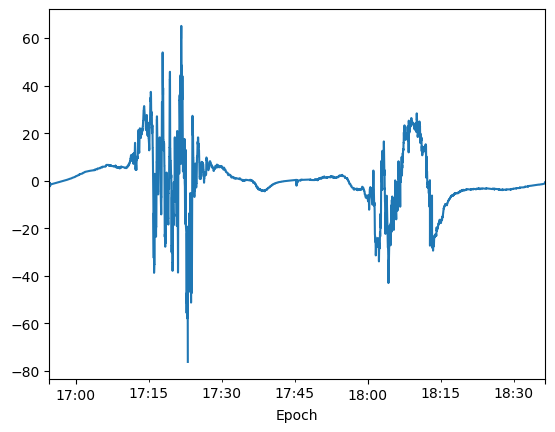

In [7]:
E['1'].plot()

In [8]:
E['1'] = E['1'].interpolate(method='linear')

In [9]:
window_size=100
mode='same'
E1_mov_ave = np.convolve(E['1'], np.ones(window_size)/window_size, mode=mode)

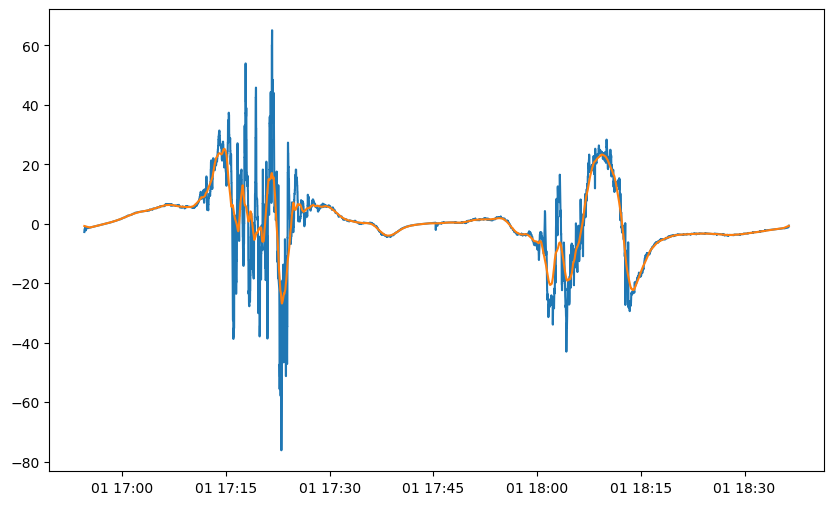

In [10]:
plt.figure(figsize=(10,6))
plt.plot(E['1'].index,E['1'])
plt.plot(E['1'].index,E1_mov_ave)

In [11]:
e1 = E['1'] - E1_mov_ave

<Axes: xlabel='Epoch'>

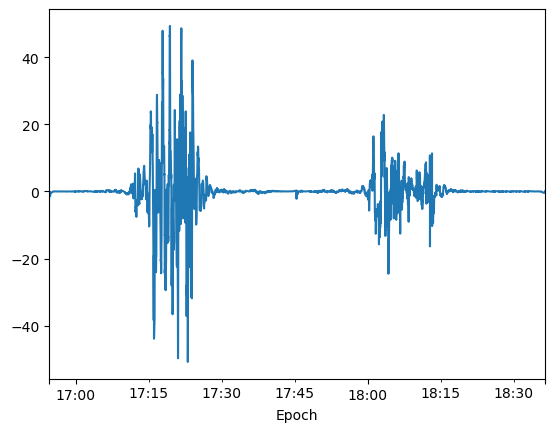

In [12]:
e1.plot()

In [13]:
# 创建 DataFrame，包含两条曲线的数据
df = pd.DataFrame({'Date':ssies3_data.index, 'e1': e1,'b2': b['2']})

# 使用 plotly 绘制交互式时间序列图
fig = px.line(df, x='Date', y=['e1', 'b2'], title='Interactive Time Series Data with Two Lines')
fig.show()


# frequency-amplitude figure

In [14]:

def comparison_before_after_interpolate(series,method='linear',figsize=(8,12)):
    """
    
    :param series: [pd.series]. the type of index is pd.datetime. 
    :param method: 
    :param figsize: 
    :return: 
    """
    # todo: print the number of nan
    series_interpolate = series.interpolate(method=method)
    x = series.index
    fig,axs = plt.subplots(3,figsize=figsize)
    axs[0].plot(x,series)
    axs[1].plot(x,series_interpolate)
    axs[2].plot(x,series,x,series_interpolate)
    plt.show()


def fre_amp(series,fs=1.0,figsize=(10, 6),figtitle='todo'):
    """
    
    :param series: [pd.series]. the type of index is pd.datetime.
    :param fs: [float]. sampling frequency.
    :return: 
    """
    series = series.interpolate(method='linear')
    n = len(series)  # 数据点总数
    f_values = np.fft.fftfreq(n, d=1/fs)  # 频率分量
    fft_values = np.fft.fft(series)  # 进行 FFT
    amplitude_spectrum = np.abs(fft_values)  # 取 FFT 的幅值
    
    # 只取正频率部分
    positive_frequencies = f_values[:n // 2]
    positive_amplitude_spectrum = amplitude_spectrum[:n // 2]
    
    # 绘制频谱图
    plt.figure(figsize=figsize)
    plt.plot(positive_frequencies, positive_amplitude_spectrum, color='red', label='origin')
    plt.xscale('linear')  # 频率线性刻度
    plt.yscale('log')  # 幅值对数刻度
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude Spectra')
    plt.title(figtitle)
    plt.legend()
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.title(f'fs={fs}')
    plt.show()
    
    # return
    return positive_frequencies, positive_amplitude_spectrum
    
    
def mov_ave(fre,amp,window_size=20,mode='same',figsize=(10,6)):
    amp = np.convolve(amp, np.ones(window_size)/window_size, mode=mode)
    # 绘制频谱图
    plt.figure(figsize=figsize)
    plt.plot(fre, amp, color='red', label='mov ave')  # mode='same'
    # plt.plot(fre[:len(amp)], amp, color='red', label='mov ave')  # mode='valid'  # it will reduce the amp length.
    plt.xscale('linear')  # 频率线性刻度
    plt.yscale('log')  # 幅值对数刻度
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude Spectra')
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.title(f'window_size={window_size}, mode={mode}')
    plt.show()
    
    return amp
    
    
def SG_smooth(fre,amp, window_length=51, polyorder=3,figsize=(10,6)):
    # 使用 Savitzky-Golay 滤波器进行平滑处理
    # window_length 必须是奇数，并且多项式阶数 polyorder 必须小于 window_length
    amp = savgol_filter(amp, window_length=window_length, polyorder=polyorder)
    # 绘制频谱图
    plt.figure(figsize=figsize)
    plt.plot(fre, amp, color='red', label='Savitzky-Golay Smoothed')
    plt.xscale('linear')  # 频率线性刻度
    plt.yscale('log')  # 幅值对数刻度
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude Spectra')
    plt.legend()
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.title(f'window_length={window_length}, polyorder={polyorder}')
    plt.show()
    
    return amp
    

def wavelet_smooth(series,method='linear',wavelet='db4',level=6,threshold=0.2,mode='soft',fs=1.0):

    # 处理缺失值 - 线性插值
    series = series.interpolate(method=method)
    # 使用小波变换进行多尺度分解
    wavelet = wavelet  # 选择小波函数，例如 'db4' (Daubechies)
    coeffs = pywt.wavedec(series, wavelet, level=level)  # 进行离散小波分解，设定分解层数
    
    # 处理高频细节系数，设置某些高频部分为零，以达到平滑效果
    threshold = threshold  # 设置阈值
    coeffs[1:] = [pywt.threshold(c, threshold, mode=mode) for c in coeffs[1:]]
    
    # 使用处理后的系数重构信号
    smoothed_signal = pywt.waverec(coeffs, wavelet)
    
    # 对平滑后的信号进行快速傅里叶变换 (FFT)
    fs = fs  # 采样频率为 1 Hz（每秒采样一次）
    n = len(smoothed_signal)  # 数据点总数
    f_values = np.fft.fftfreq(n, d=1/fs)  # 频率分量
    fft_values = np.fft.fft(smoothed_signal)  # 对平滑后的信号进行 FFT
    amplitude_spectrum = np.abs(fft_values)  # 取 FFT 的幅值
    
    # 只取正频率部分
    wavelet_positive_frequencies = f_values[:n // 2]
    wavelet_positive_amplitude_spectrum = amplitude_spectrum[:n // 2]
    
    # 绘制平滑后的频谱图
    plt.figure(figsize=(10, 6))
    plt.plot(wavelet_positive_frequencies, wavelet_positive_amplitude_spectrum, color='red', label='Smoothed with Wavelet')
    plt.xscale('linear')  # 频率线性刻度
    plt.yscale('log')  # 幅值对数刻度
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude Spectra')
    plt.legend()
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.title(f'method={method}, wavelet={wavelet}, level={level}, threshold={threshold}, mode={mode}, fs={fs}')
    plt.show()
    
    return wavelet_positive_frequencies,wavelet_positive_amplitude_spectrum


In [15]:
def draw_ori_smooth_comparison(fre,amp,amp_mov_ave,amp_SG,fre_wavelet,amp_wavelet,figsize=(20,18)):
    fig=plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 2)  # 3 行 2 列的网格
    # 0
    ax1 = fig.add_subplot(gs[0, :])  # 第 0 行，跨越所有列
    ax1.plot(fre,amp,label='origin')
    ax1.plot(fre,amp_mov_ave,label='mov_ave')
    ax1.plot(fre,amp_SG,label='SG')
    ax1.plot(fre_wavelet,amp_wavelet,label='wavelet')
    ax1.set_xscale('linear')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(which='both', linestyle='--', linewidth=0.5)
    
    # 1,0
    ax10 = fig.add_subplot(gs[1, 0])  # 第 1 行，第 0 列
    ax10.plot(fre,amp,label='origin')
    ax10.set_xscale('linear')
    ax10.set_yscale('log')
    ax10.set_title('origin')
    # 1,1
    ax11 = fig.add_subplot(gs[1, 1])
    ax11.plot(fre,amp_mov_ave,label='mov_ave')
    ax11.set_xscale('linear')
    ax11.set_yscale('log')
    ax11.set_title('mov ave')
    # 2,0
    ax20 = fig.add_subplot(gs[2, 0])
    ax20.plot(fre,amp_SG,label='SG')
    ax20.set_xscale('linear')
    ax20.set_yscale('log')
    ax20.set_title('SG')
    # 2,1
    ax21 = fig.add_subplot(gs[2, 1])
    ax21.plot(fre_wavelet,amp_wavelet,label='wavelet')
    ax21.set_xscale('linear')
    ax21.set_yscale('log')
    ax21.set_title('wavelet')
    # show figure
    plt.tight_layout()
    plt.show()
    

# e1

In [16]:
e1_interpolate = e1.interpolate(method='linear')

In [17]:
clip = ['2014-01-01 17:13:14', '2014-01-01 17:26:36']
# clip = ['2014-01-01 17:15:00', '2014-01-01 17:17:00']  # too short, just 120 data points


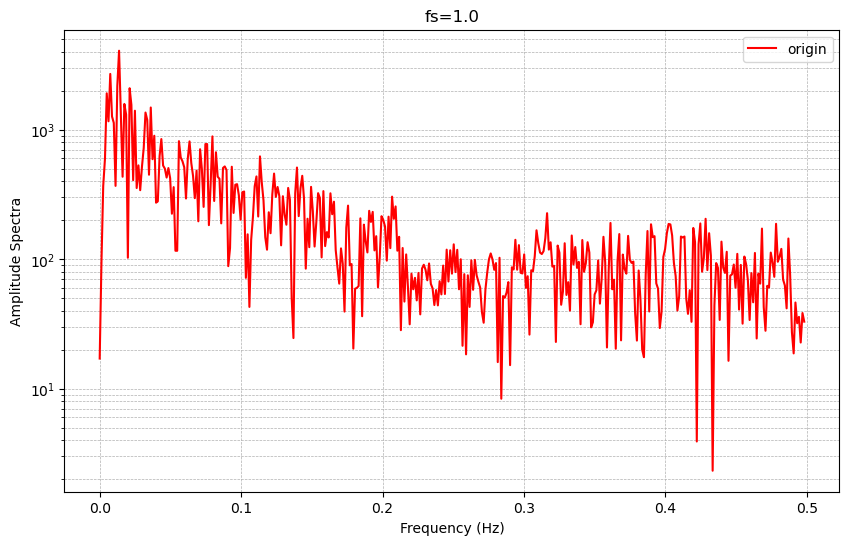

In [18]:
e1 = e1[clip[0]:clip[1]]
e1_fre,e1_amp = fre_amp(e1)

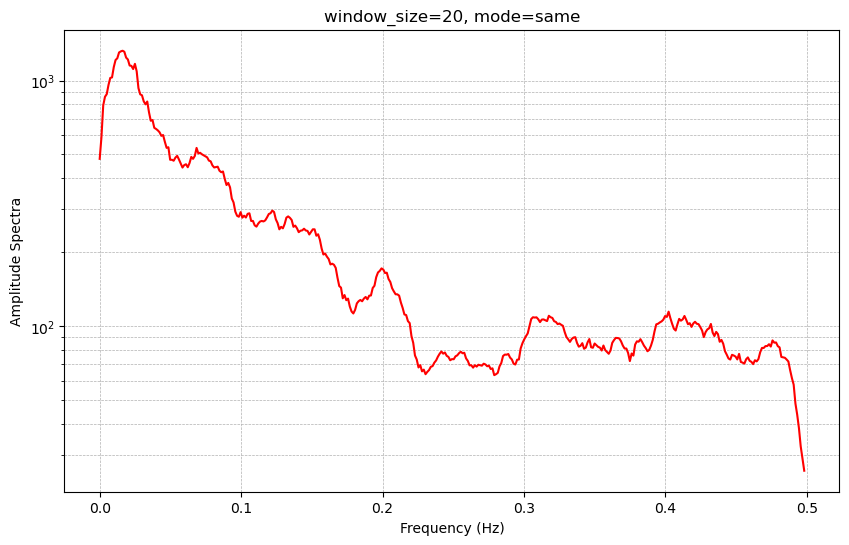

In [19]:
e1_amp_mov_ave=mov_ave(e1_fre,e1_amp)

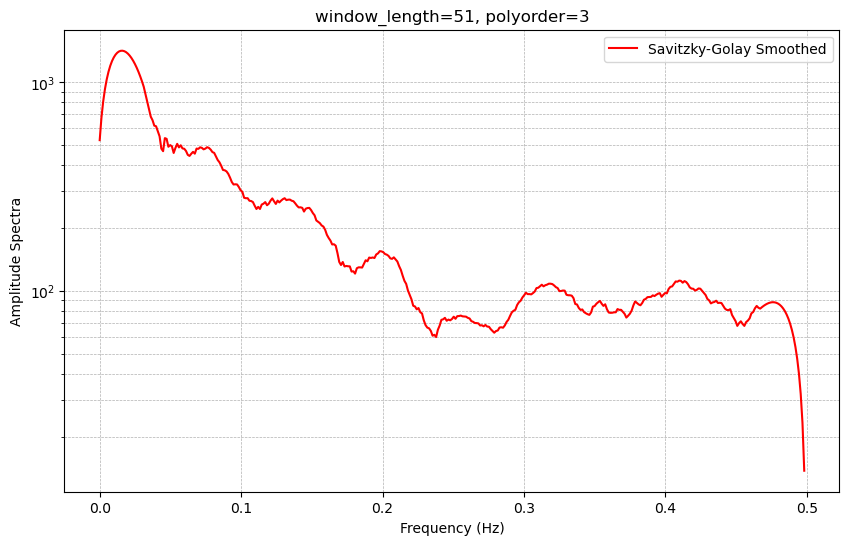

In [20]:
e1_amp_SG=SG_smooth(e1_fre,e1_amp)

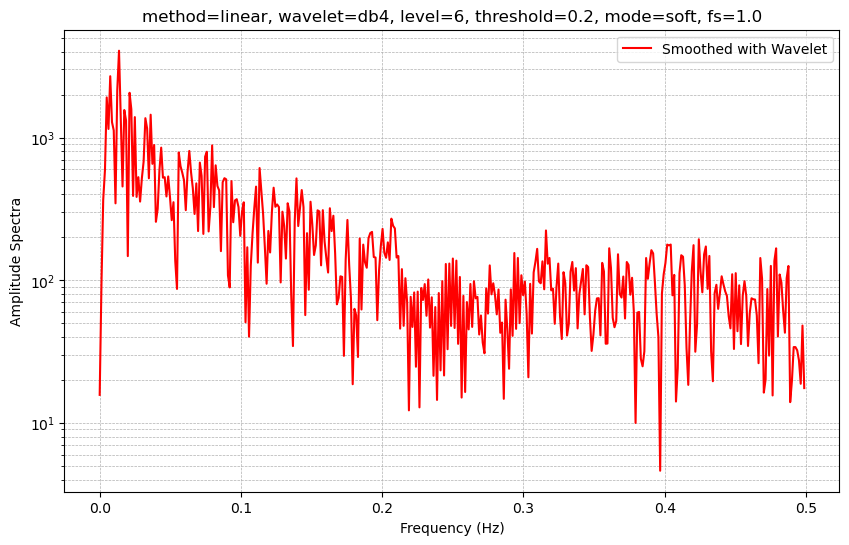

In [21]:
e1_fre_wavelet,e1_amp_wavelet=wavelet_smooth(e1)

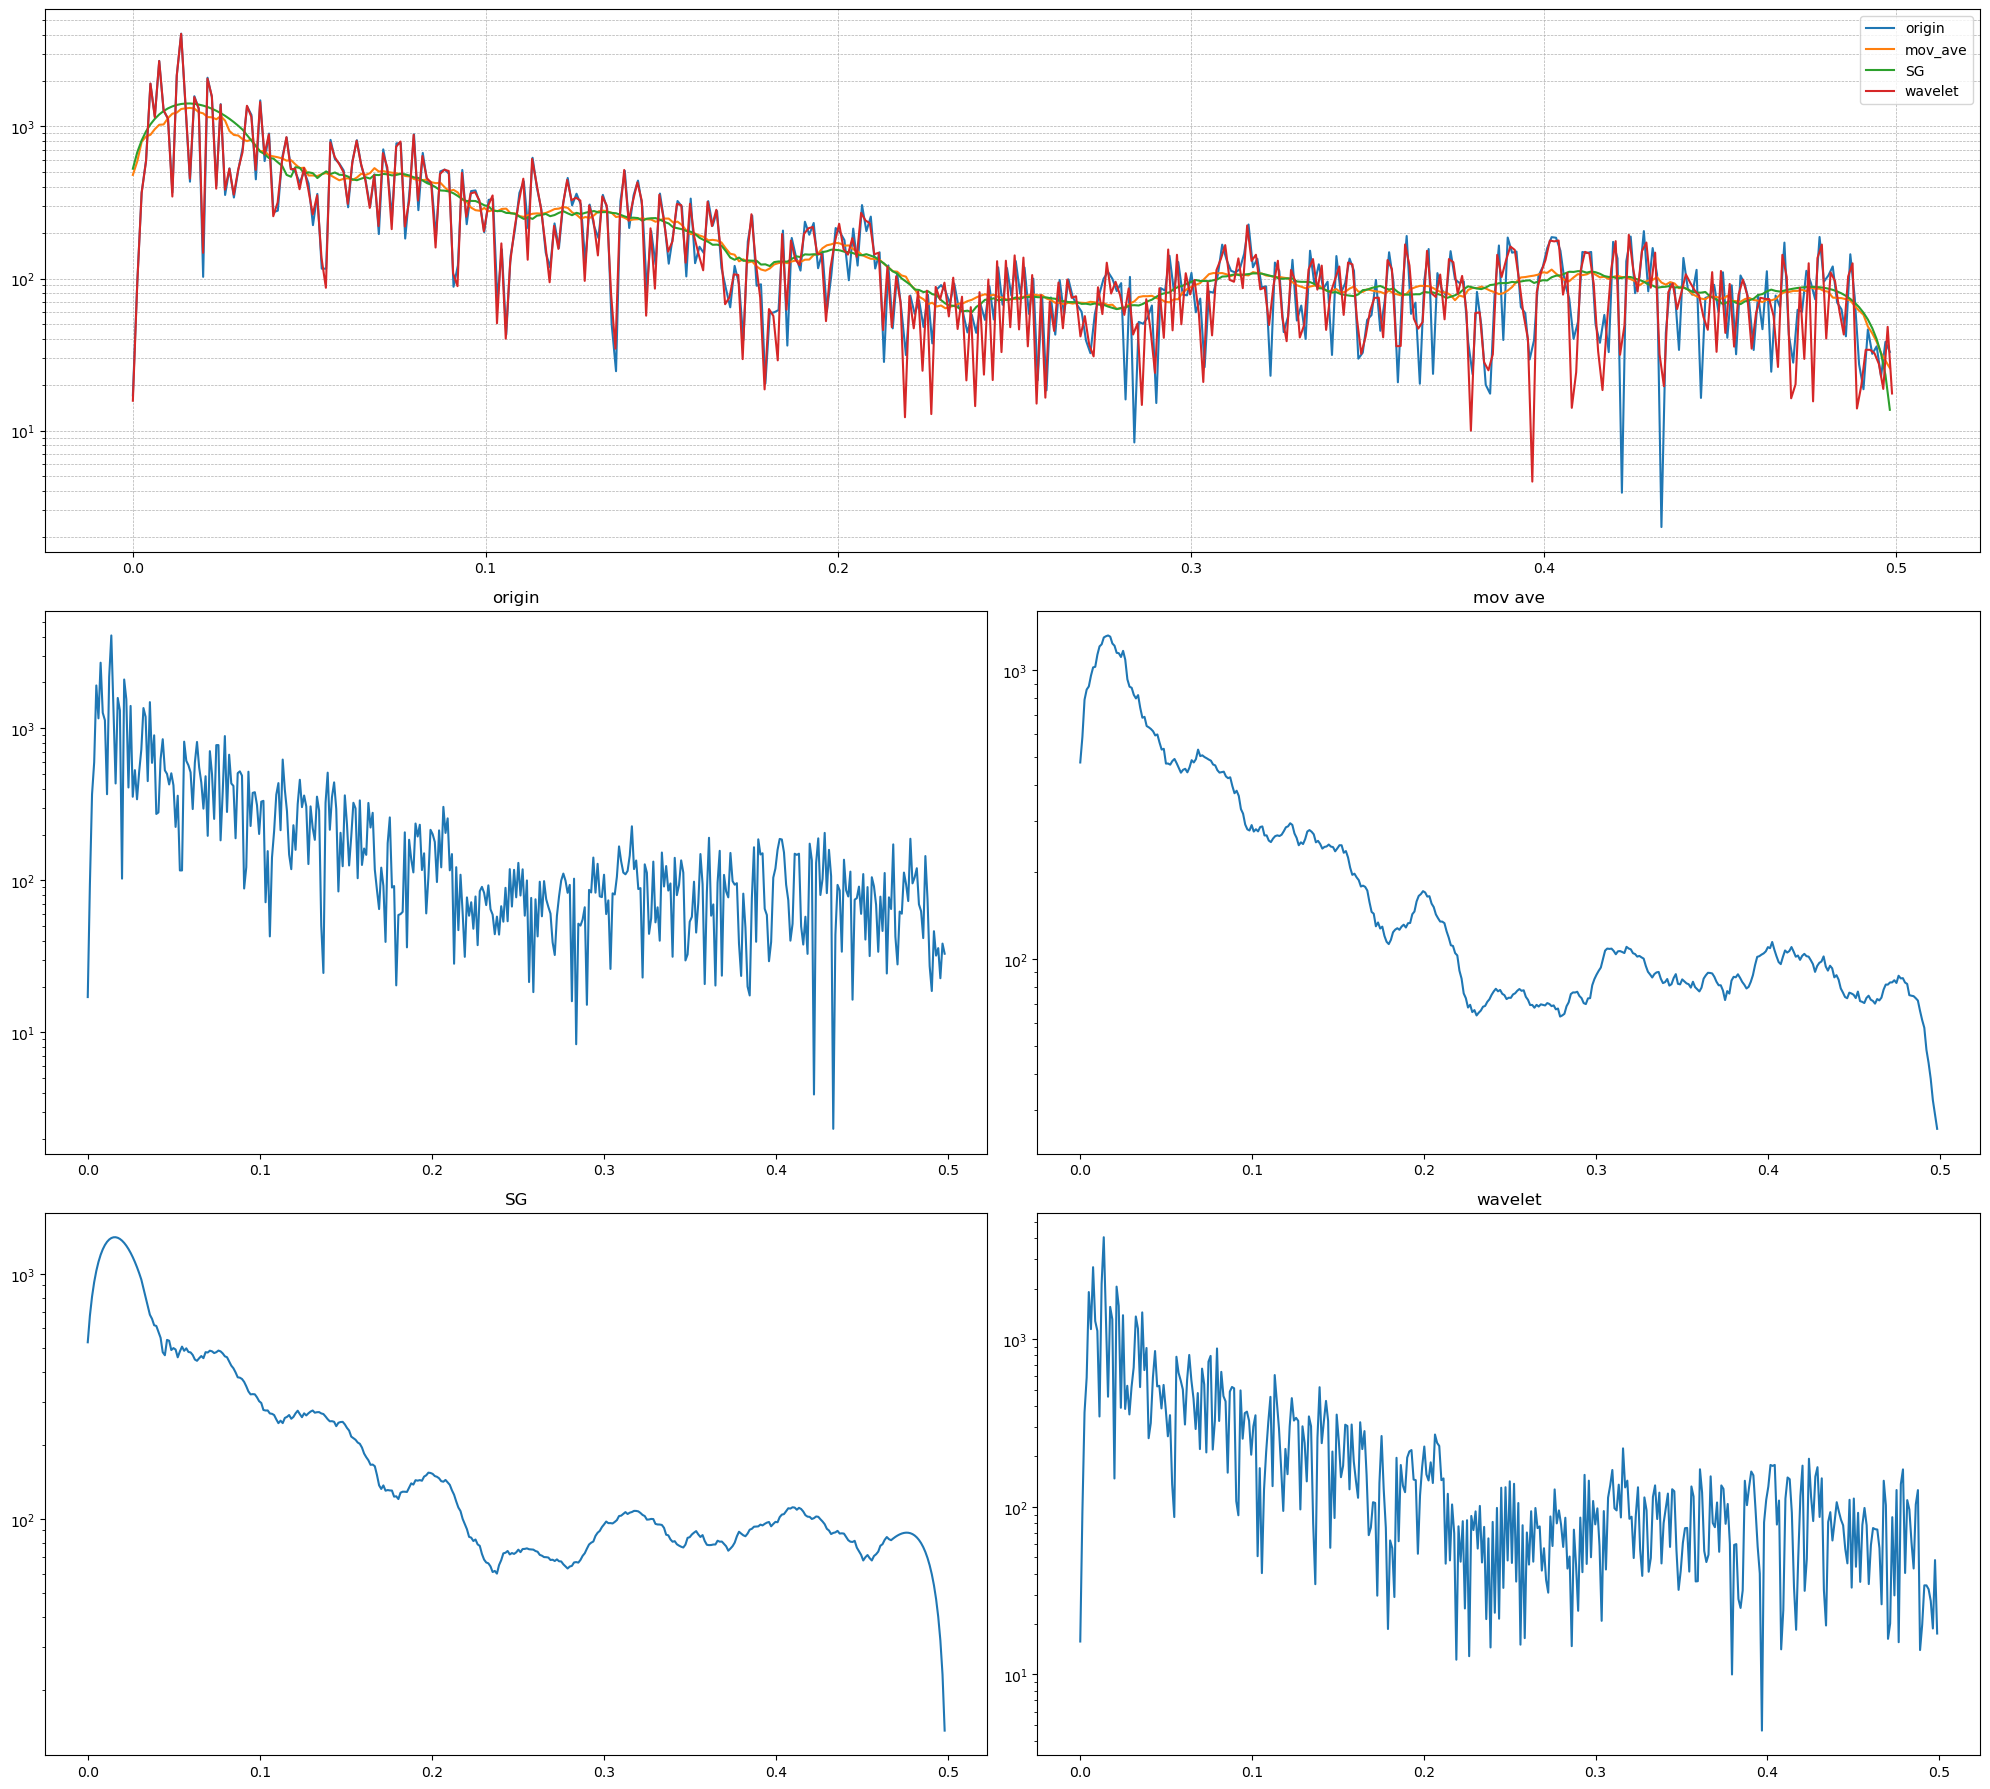

In [22]:
draw_ori_smooth_comparison(e1_fre,e1_amp,e1_amp_mov_ave,e1_amp_SG,e1_fre_wavelet,e1_amp_wavelet)

# b2

<Axes: xlabel='Epoch'>

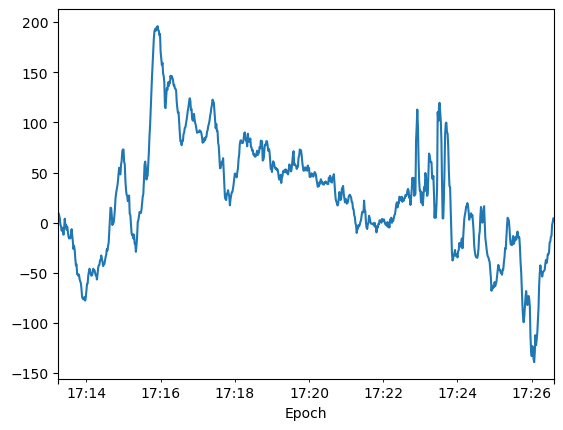

In [23]:
b2 = b['2'][clip[0]:clip[1]]
b2.plot()

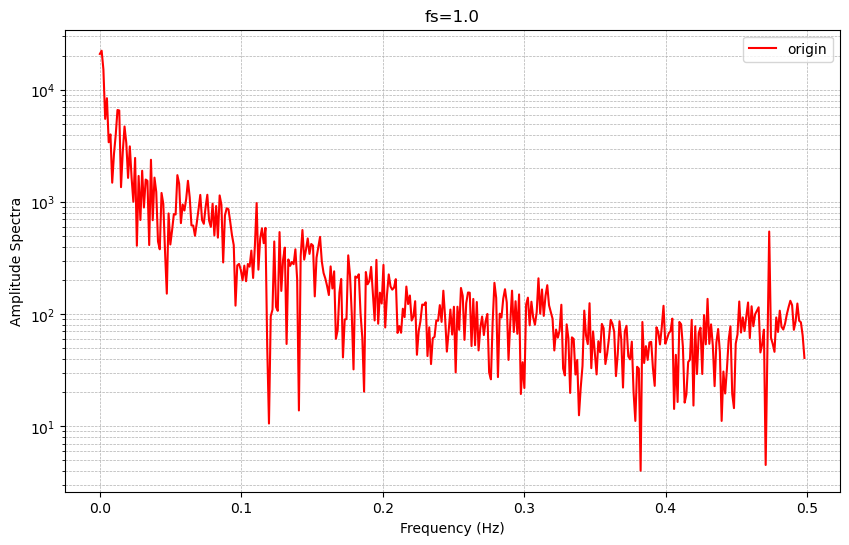

In [24]:
b2_fre,b2_amp = fre_amp(b2)

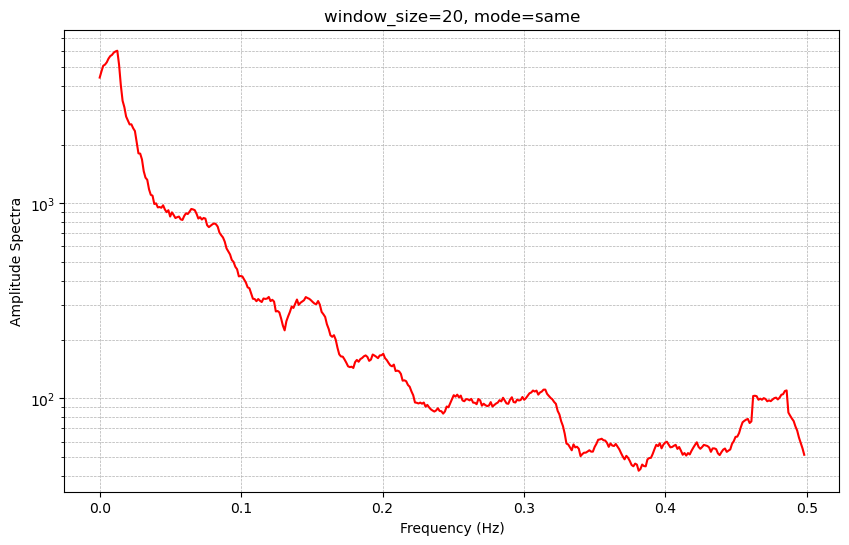

In [25]:
b2_amp_mov_ave=mov_ave(b2_fre,b2_amp)

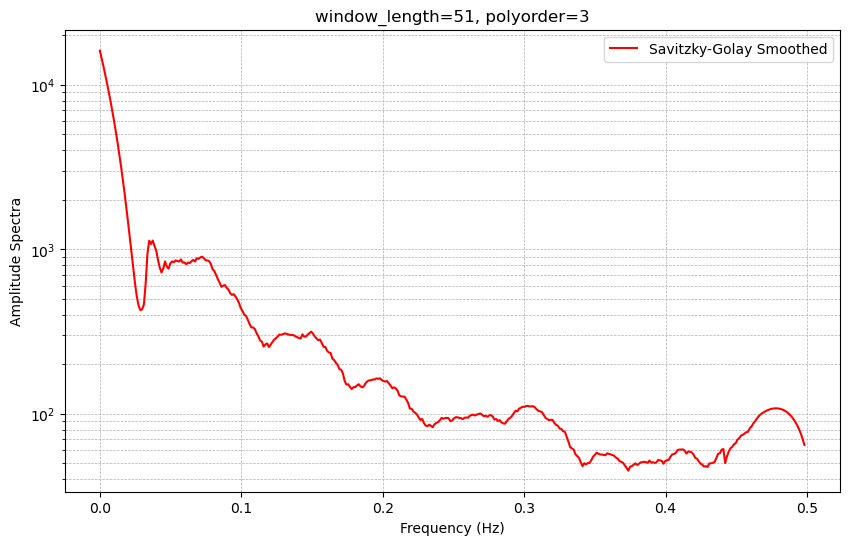

In [26]:
b2_amp_SG=SG_smooth(b2_fre,b2_amp)

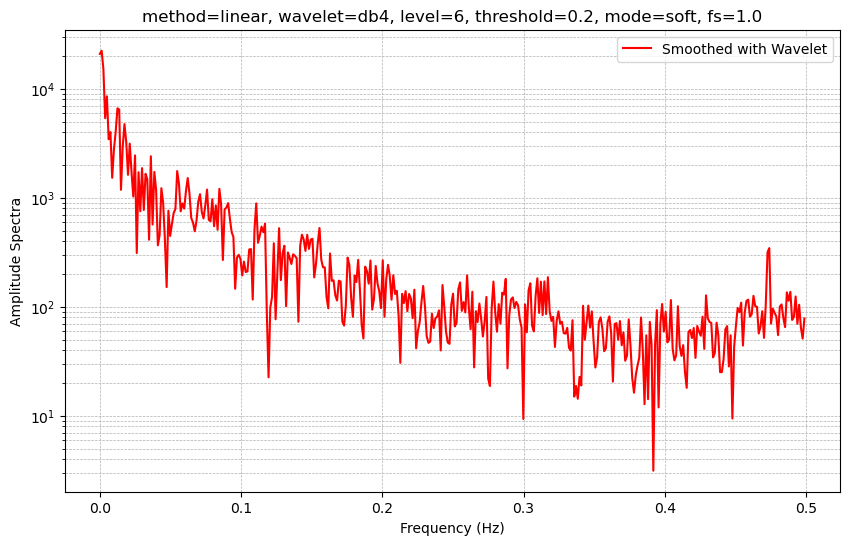

In [27]:
b2_fre_wavelet,b2_amp_wavelet=wavelet_smooth(b2)

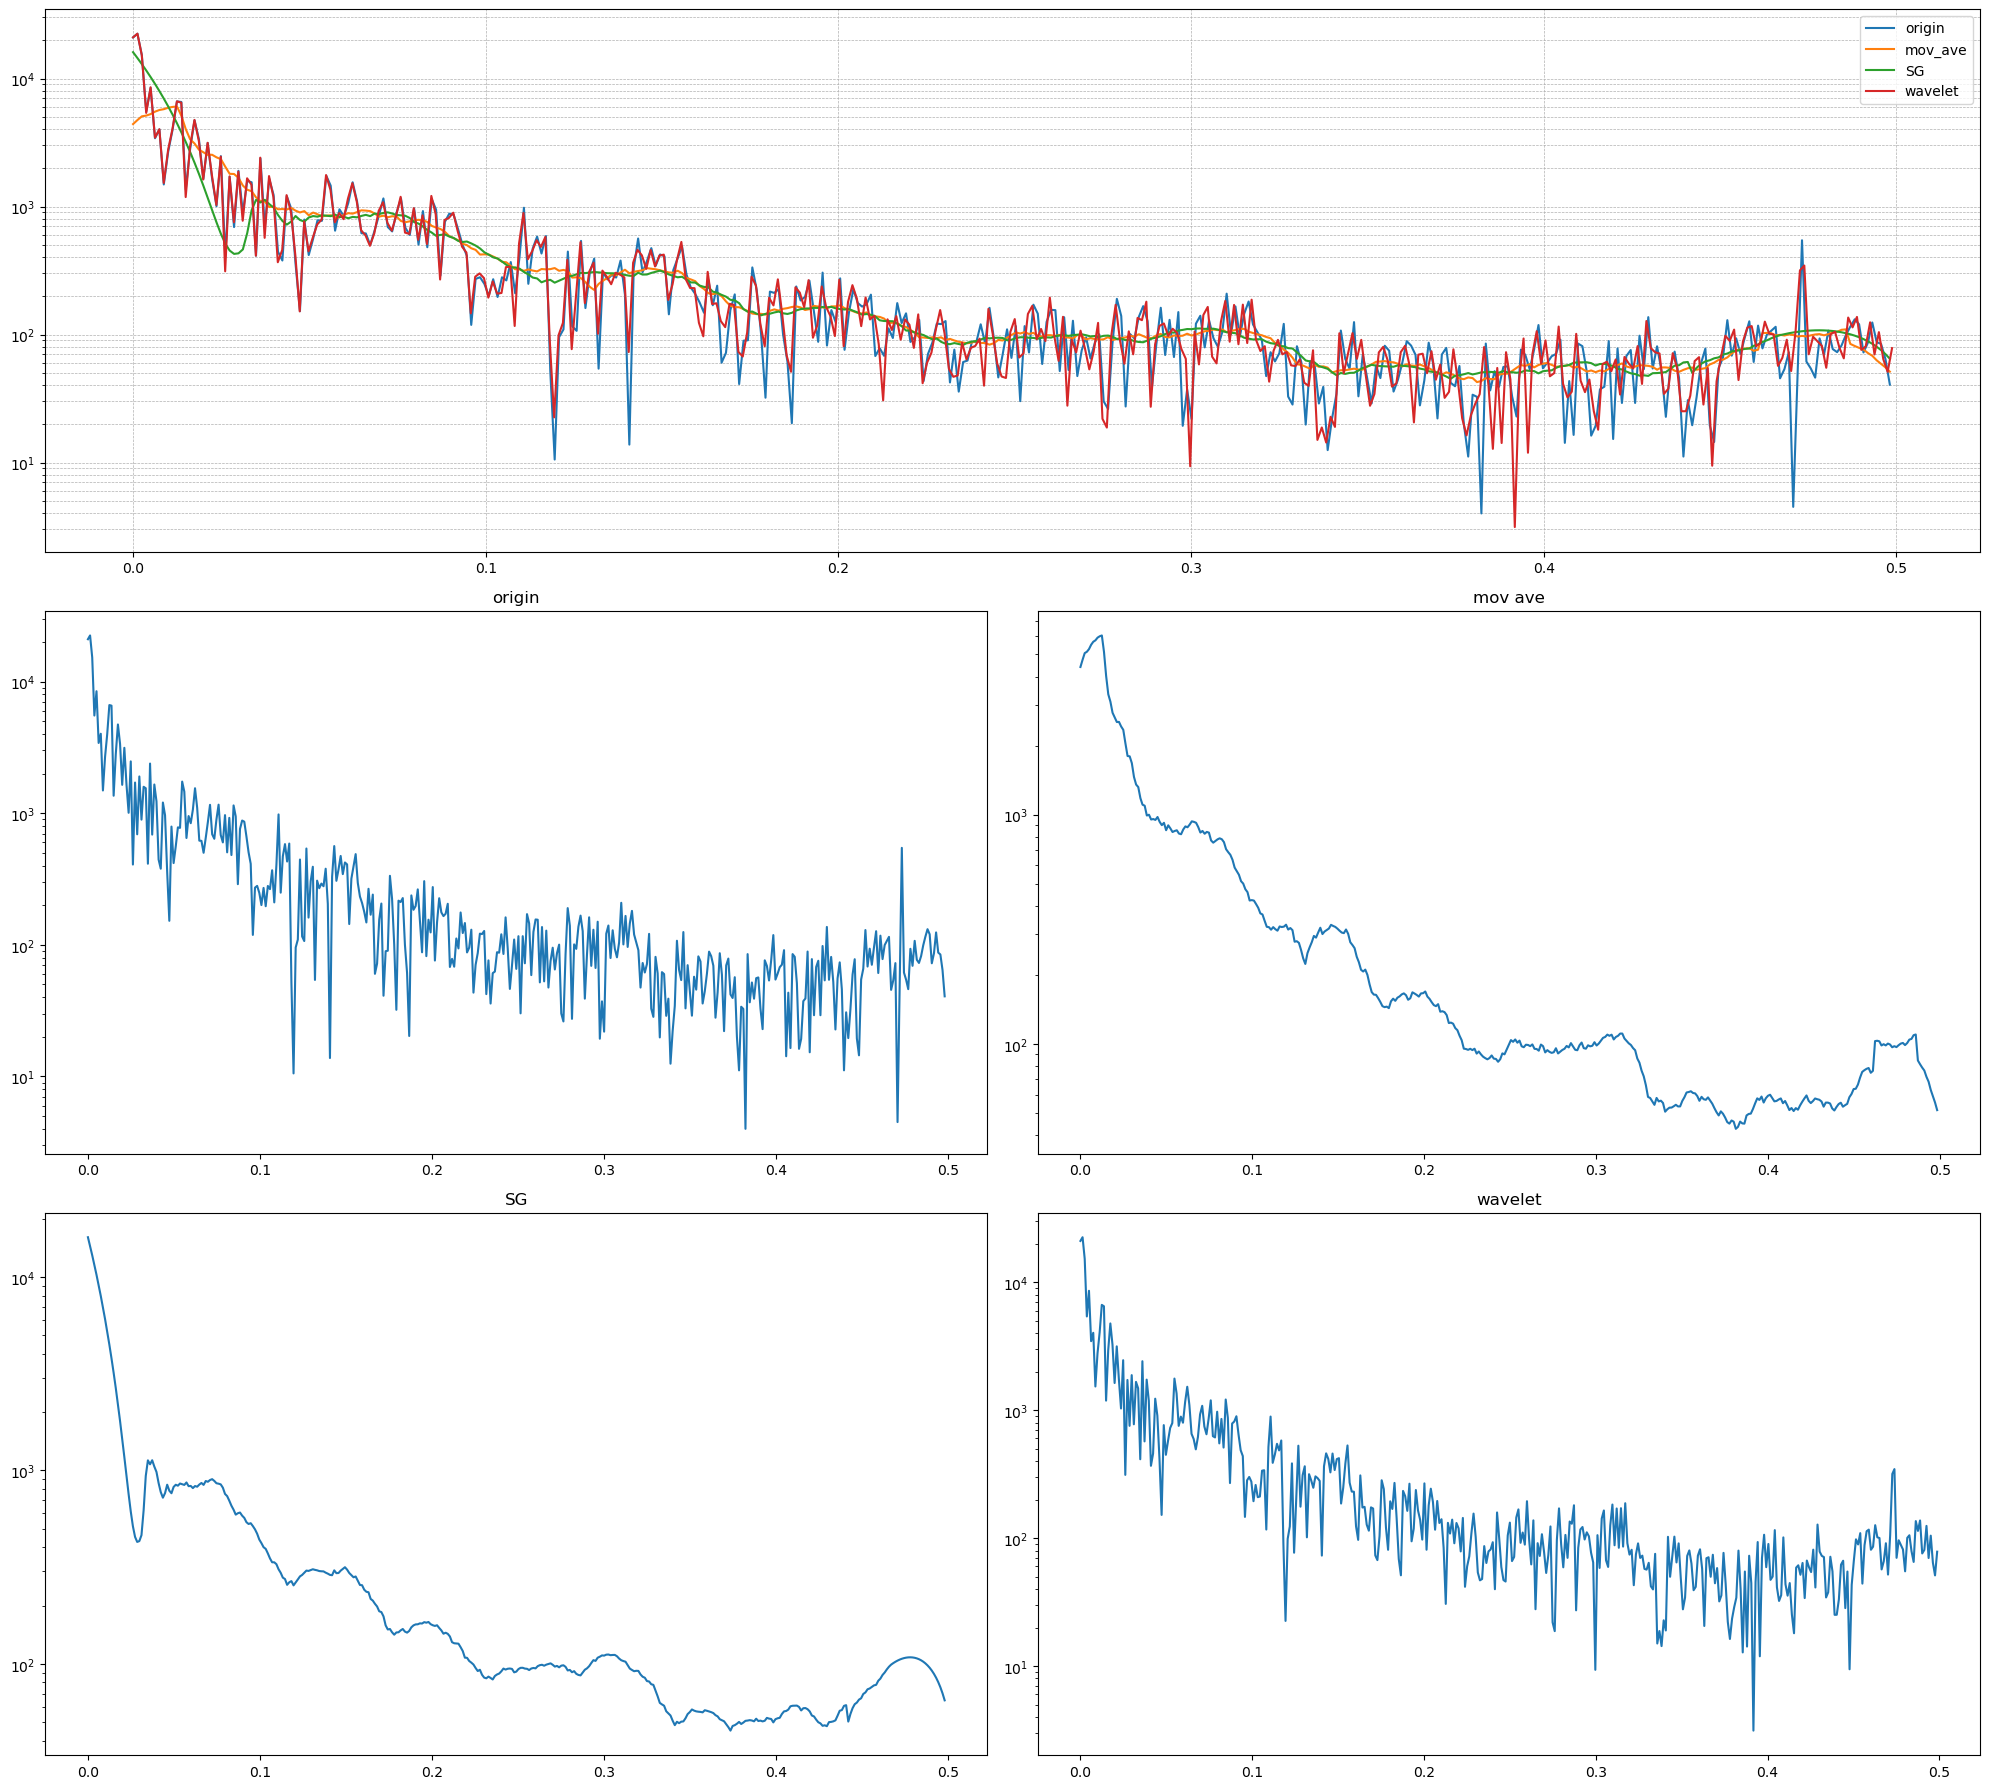

In [28]:
draw_ori_smooth_comparison(b2_fre,b2_amp,b2_amp_mov_ave,b2_amp_SG,b2_fre_wavelet,b2_amp_wavelet)

# choose mov ave

In [29]:
def draw_ori_mov_ave_comparison(fre,amp,amp_mov_ave,figsize=(10,6)):
    plt.figure(figsize=figsize)
    plt.plot(fre,amp,label='origin')
    plt.plot(fre,amp_mov_ave,label='mov_ave')
    plt.xscale('linear')
    plt.yscale('log')
    plt.legend()
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.show()
    
    

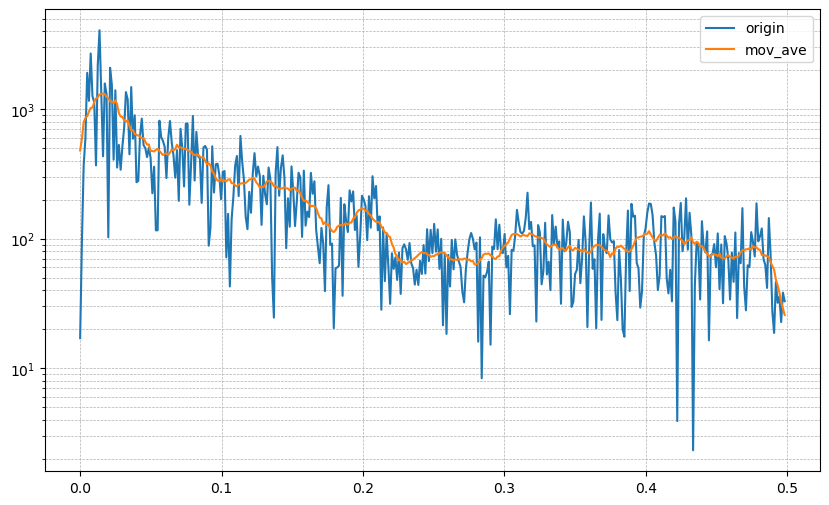

In [30]:
draw_ori_mov_ave_comparison(e1_fre,e1_amp,e1_amp_mov_ave)

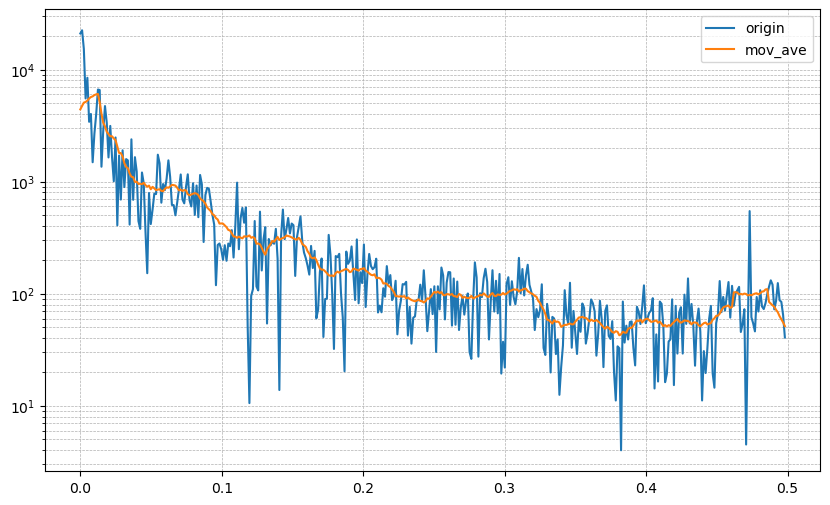

In [31]:
draw_ori_mov_ave_comparison(b2_fre,b2_amp,b2_amp_mov_ave)

In [32]:
def draw_e1_b2_smooth(e1_fre,e1_amp_mov_ave,b2_fre,b2_amp_mov_ave,figsize=(10,6)):
    plt.figure(figsize=figsize)
    plt.plot(e1_fre,e1_amp_mov_ave,label='E1')
    plt.plot(b2_fre,b2_amp_mov_ave,label='b2')
    plt.xscale('linear')
    plt.yscale('log')
    plt.legend()
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.show()

# ratio

In [33]:
np.array_equal(e1_fre,b2_fre)  # why equal? (refer to fft)

True

In [34]:
ratio = (e1_amp_mov_ave * 1e-3) / (b2_amp_mov_ave * 1e-9)

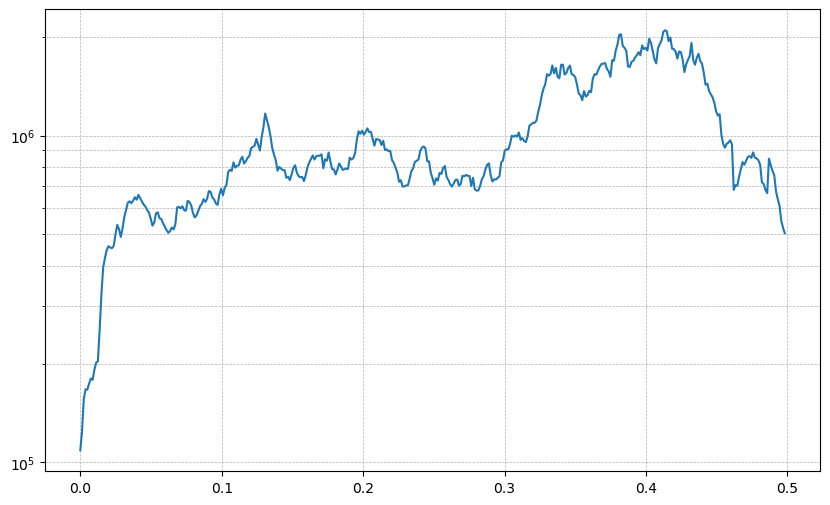

In [35]:
plt.figure(figsize=(10,6))
plt.plot(e1_fre,ratio)
plt.xscale('linear')
plt.yscale('log')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

# va

In [36]:
def get_va(B01,B02,B03,dens,fraco,frach,frache):
    denominator = np.sqrt(mu0 * (fraco*dens*mo + frach*dens*mh + frache*dens*mhe)) * 1e3
    va1 = (B01 * 1e-9) / denominator
    va2 = (B02 * 1e-9) / denominator
    va3 = (B03 * 1e-9) / denominator
    return va1,va2,va3

In [37]:
va1,va2,va3 = get_va(B01,B02,B03,ssies3_data['ductdens'],ssies3_data['fraco'],ssies3_data['frach'],ssies3_data['frache'])

In [38]:
va = np.sqrt(va1**2 + va2**2 + va3**2)

<Axes: xlabel='Epoch'>

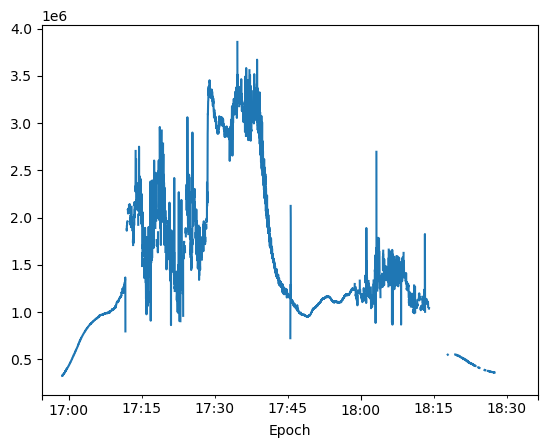

In [39]:
va.plot()

<Axes: xlabel='Epoch'>

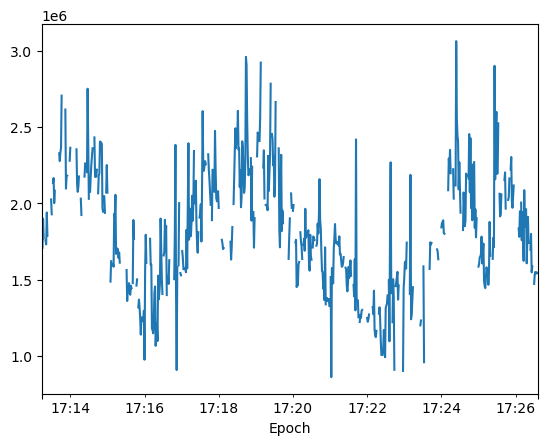

In [40]:
va = va[clip[0]:clip[1]]
va.plot()

(<Axes: xlabel='Epoch'>, <Axes: xlabel='Epoch'>, <Axes: xlabel='Epoch'>)

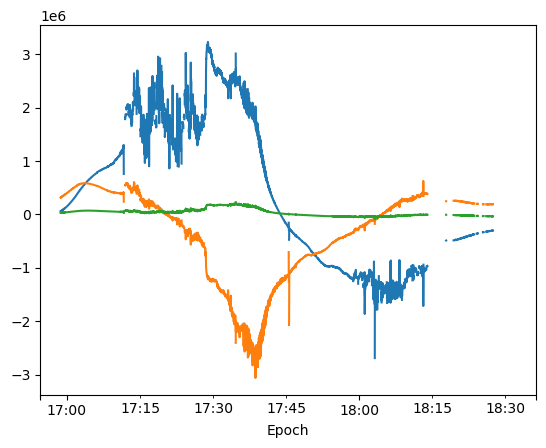

In [41]:
va1.plot(),va2.plot(),va3.plot()

# add va to ratio

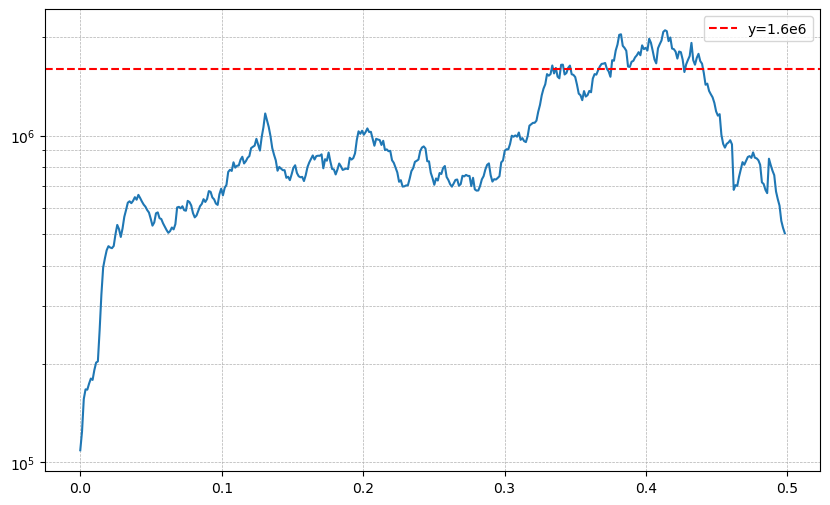

In [42]:
plt.figure(figsize=(10,6))
plt.plot(e1_fre,ratio)
plt.axhline(y=1.6e6, color='red', linestyle='--', linewidth=1.5, label='y=1.6e6')
plt.xscale('linear')
plt.yscale('log')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [43]:
# plt.figure(figsize=(10,6))
# plt.plot(E1_fre,ratio)
# plt.plot()  # x轴的变化？？？ 还是对va也进行fft？
# plt.xscale('linear')
# plt.yscale('log')
# plt.grid(which='both', linestyle='--', linewidth=0.5)
# plt.show()

# E1 and b2

## Savitzky-Golay

## 小波

In [44]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import pywt
# 
# # 处理缺失值 - 线性插值
# E['1'] = E['1'].interpolate(method='linear')
# 
# # 使用小波变换
# wavelet = 'db4'  # 选择小波函数，例如 'db4' (Daubechies)
# coeffs = pywt.wavedec(E['1'], wavelet, level=6)  # 进行离散小波变换，设定分解层数
# 
# # 计算每个分量的频谱能量
# plt.figure(figsize=(12, 8))
# for i, coef in enumerate(coeffs[1:], 1):  # 跳过第一个近似分量
#     plt.subplot(len(coeffs) - 1, 1, i)
#     plt.plot(coef, color='blue')
#     plt.title(f'Detail Coefficients (Level {i})')
#     plt.grid()
# 
# plt.tight_layout()
# plt.show()


In [45]:
## together

# b

In [46]:
# # 修改阈值大小以观察平滑效果
# thresholds = [0.1, 1, 10]
# 
# plt.figure(figsize=(15, 8))
# 
# for i, threshold in enumerate(thresholds):
#     # 小波分解
#     coeffs = pywt.wavedec(E['1'], 'db4', level=6)
#     # 应用阈值
#     coeffs[1:] = [pywt.threshold(c, threshold, mode='soft') for c in coeffs[1:]]
#     # 信号重构
#     smoothed_signal = pywt.waverec(coeffs, 'db4')
#     
#     # FFT
#     fft_values = np.fft.fft(smoothed_signal)
#     amplitude_spectrum = np.abs(fft_values)
#     positive_frequencies = f_values[:n // 2]
#     positive_amplitude_spectrum = amplitude_spectrum[:n // 2]
#     
#     # 绘制频谱图
#     plt.subplot(len(thresholds), 1, i + 1)
#     plt.plot(positive_frequencies, positive_amplitude_spectrum, label=f'Threshold = {threshold}')
#     plt.xscale('linear')
#     plt.yscale('log')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Amplitude Spectra')
#     plt.title(f'Amplitude Spectrum (Threshold = {threshold})')
#     plt.legend()
#     plt.grid(which='both', linestyle='--', linewidth=0.5)
# 
# plt.tight_layout()
# plt.show()


## 不同方法平滑对比